# Clustering

CS-E4650 Methods of Data mining: Project work

The task of this project is to cluster two data sets as well as possible. The first dataset contains gene expression data while the second is about mass spectrometry. The goodness of the clustering is evaluated with normalized mutual information (NMI). In this notebook, mass spectrometry clustering is performed.

## Data 2: Mass spectrometry

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import operator
import random

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn import metrics
from sklearn.utils import shuffle

from scipy.cluster.hierarchy import linkage, centroid, fcluster, fclusterdata
from scipy.spatial.distance import pdist

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering
from sklearn import preprocessing

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif



### Data ETL

In [2]:
df_ms= pd.read_csv("msdata.csv")

In [11]:
df_ms.head()

,id,class,f1,f2,f3,f4,f5,f6,f7,f8,...,f4991,f4992,f4993,f4994,f4995,f4996,f4997,f4998,f4999,f5000
0,1,1,14.3704,13.5189,15.2479,13.8274,14.2323,13.2383,16.1178,13.2488,...,16.0304,13.3344,16.0211,10.0160,15.2300,13.1752,14.8580,17.1991,17.1206,13.0425
1,2,1,16.6945,13.3035,16.5303,15.2523,15.7153,15.6161,18.3479,14.6787,...,17.4675,15.3745,17.5870,14.3768,16.1388,14.5012,15.3480,16.3339,19.2920,13.4911
2,3,1,16.1807,13.3308,16.1866,12.3704,13.9519,15.1695,17.2757,14.3283,...,16.1209,15.0801,18.0217,13.3382,15.7998,14.2165,15.3336,17.2670,18.9402,13.0222
3,4,1,16.8705,13.1743,16.2900,15.4931,14.8954,14.4440,16.0538,13.2912,...,16.4285,12.3385,15.8880,8.4838,14.8774,12.8094,14.7309,15.6526,17.5066,13.1212
4,5,1,16.2108,13.1175,17.1489,14.8416,15.5158,15.0314,16.7884,14.6162,...,17.5532,15.3416,17.6385,11.4521,15.9572,14.7070,15.4503,19.3039,19.0848,12.8876


In [12]:
df_ms.shape

(694, 5002)

In [13]:
df_ms.groupby(['class']).size()

class
1    125
2    259
3    310
dtype: int64

In [14]:
# Check for possible null values.
df_ms[df_ms.isnull().any(axis=1)]

,id,class,f1,f2,f3,f4,f5,f6,f7,f8,...,f4991,f4992,f4993,f4994,f4995,f4996,f4997,f4998,f4999,f5000


In [3]:
# Drop class and id columns for clustering.
df_ms_cleaned = df_ms.drop('id', 1)
df_ms_cleaned = df_ms_cleaned.drop('class', 1)
df_ms_cleaned.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f4991,f4992,f4993,f4994,f4995,f4996,f4997,f4998,f4999,f5000
0,14.3704,13.5189,15.2479,13.8274,14.2323,13.2383,16.1178,13.2488,17.0401,13.4350,...,16.0304,13.3344,16.0211,10.0160,15.2300,13.1752,14.8580,17.1991,17.1206,13.0425
1,16.6945,13.3035,16.5303,15.2523,15.7153,15.6161,18.3479,14.6787,15.7241,14.0165,...,17.4675,15.3745,17.5870,14.3768,16.1388,14.5012,15.3480,16.3339,19.2920,13.4911
2,16.1807,13.3308,16.1866,12.3704,13.9519,15.1695,17.2757,14.3283,17.9922,15.2093,...,16.1209,15.0801,18.0217,13.3382,15.7998,14.2165,15.3336,17.2670,18.9402,13.0222
3,16.8705,13.1743,16.2900,15.4931,14.8954,14.4440,16.0538,13.2912,15.5441,13.6822,...,16.4285,12.3385,15.8880,8.4838,14.8774,12.8094,14.7309,15.6526,17.5066,13.1212
4,16.2108,13.1175,17.1489,14.8416,15.5158,15.0314,16.7884,14.6162,19.8109,15.7747,...,17.5532,15.3416,17.6385,11.4521,15.9572,14.7070,15.4503,19.3039,19.0848,12.8876


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13c3437d0>]],
      dtype=object)

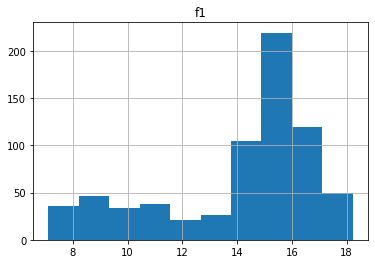

In [106]:
df_ms_cleaned.hist(column='f1')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13ba24710>]],
      dtype=object)

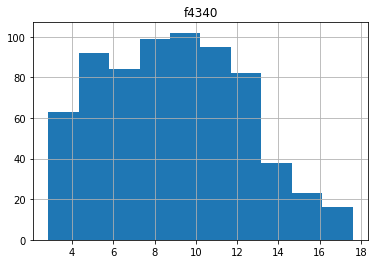

In [107]:
df_ms_cleaned.hist(column="f4340")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13bd7ed90>]],
      dtype=object)

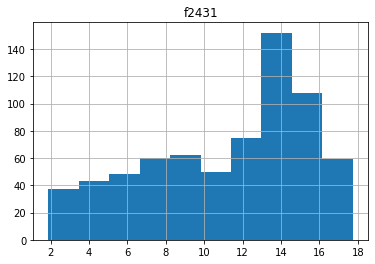

In [109]:
df_ms_cleaned.hist(column="f2431")

The dataset contains 5000 features, and 694 data points in 3 different classes. No values are missing.

### Clustering

In this section, different clustering methods are performed.

#### K-Means

Analyzing the optimal number of clusters using Silhouette coefficent, Calinski Harabasz coefficent, Davies-Bouldin coefficent, and the elbow method.

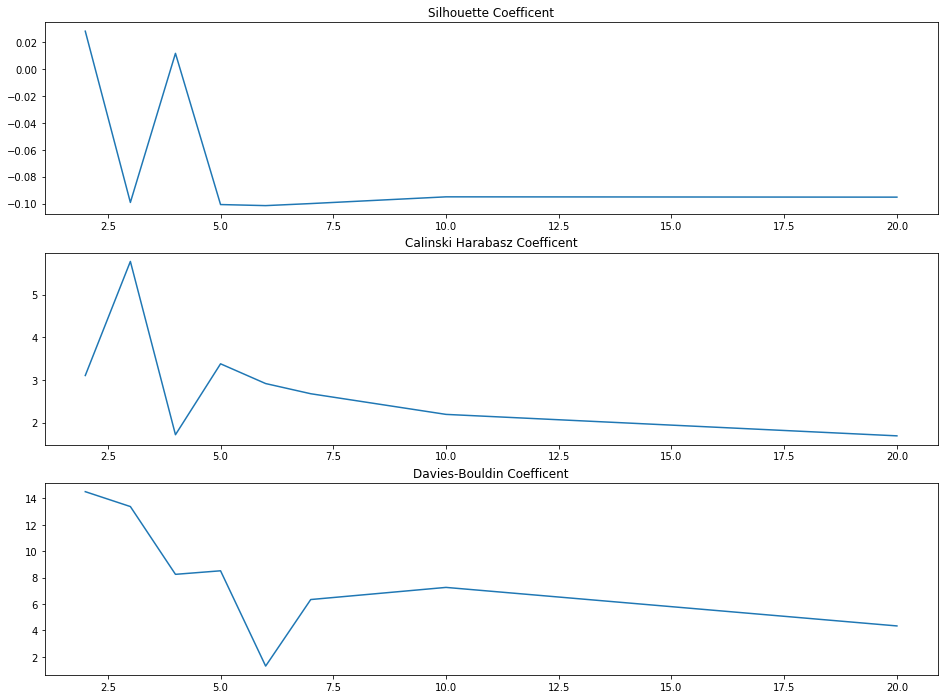

In [25]:
silhouette=[]
calinski=[]
davies=[]
K=[2, 3, 4, 5, 6, 7, 10, 20]
for i in K:
    kmeans_model = KMeans(n_clusters=i)
    kmeans_model = kmeans_model.fit(df_ms_cleaned)
    labels = kmeans_model.labels_
    silhouette.append(metrics.silhouette_score(df_ms_cleaned, labels))
    calinski.append(metrics.calinski_harabasz_score(df_ms_cleaned, labels))
    davies.append(metrics.davies_bouldin_score(df_ms_cleaned, labels))

fig, axs = plt.subplots(3, figsize=(16,12))
axs[0].plot(K, silhouette)
axs[1].plot(K, calinski)
axs[2].plot(K, davies)
axs[0].title.set_text('Silhouette Coefficent')
axs[1].title.set_text('Calinski Harabasz Coefficent')
axs[2].title.set_text('Davies-Bouldin Coefficent')
plt.show()

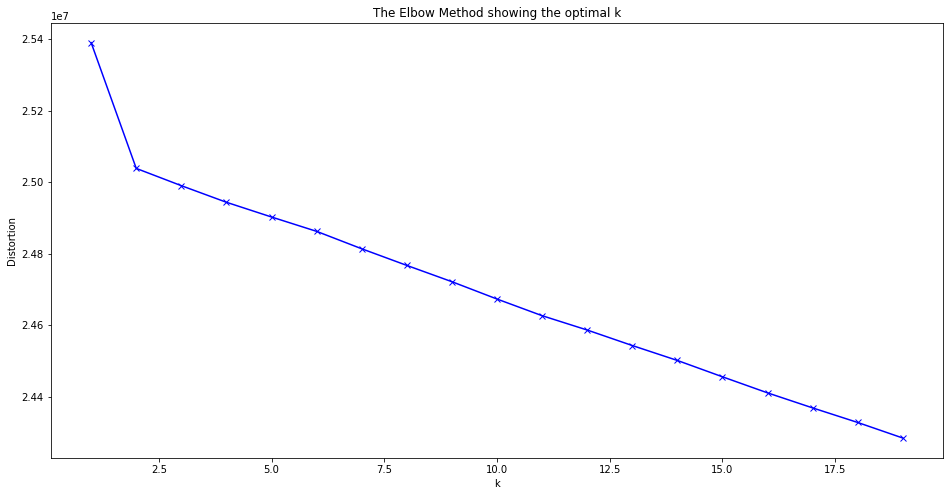

In [26]:
distortions = []
K = range(1, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_ms_cleaned)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
plt.show()

The optimal number of clusters seems to be around 3. However, also other values shall be tested. Reasoning:
* In the Elbow Method, the optimal k is at the elbow, which seems to be around k=3.
* Sihuette: The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. => Value is greatest with k=2.
* Calinski Harabasz: Higher value is better. The maximum is at k=3.
* Davies-Bouldin: The minimum score is zero, with lower values indicating better clustering. => Minimum at k=6.

##### Visualizing different k-values using PCA

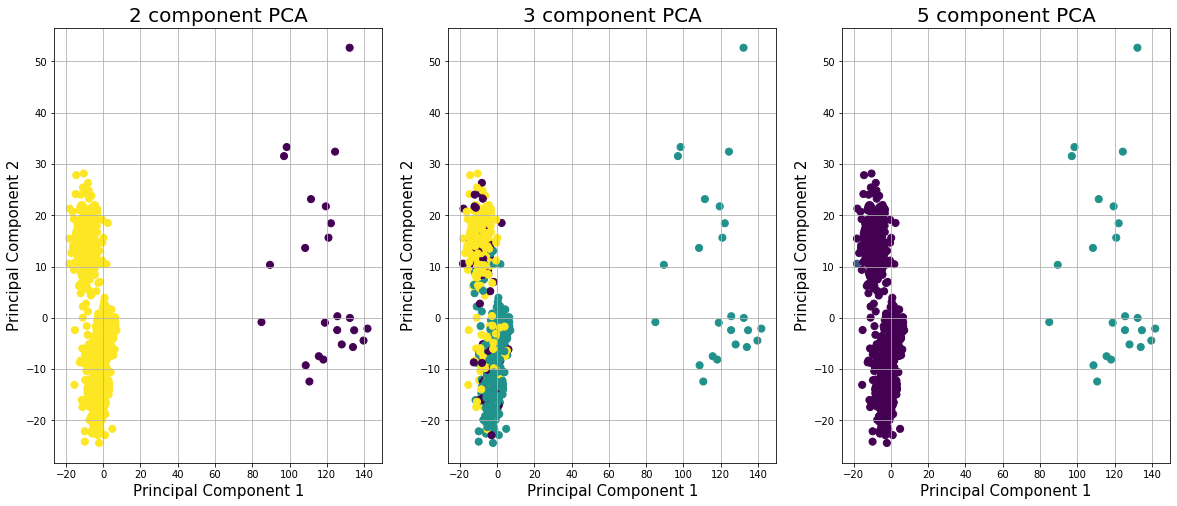

In [18]:
clusterer = KMeans(n_clusters=2)
labels2 = clusterer.fit_predict(df_ms_cleaned)
clusterer = KMeans(n_clusters=3)
labels3 = clusterer.fit_predict(df_ms_cleaned)
clusterer = KMeans(n_clusters=5)
labels5 = clusterer.fit_predict(df_ms_cleaned)
    
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_ms_cleaned)
fig, axes = plt.subplots(1, 3, figsize=(20,8))
axes[0].set_xlabel('Principal Component 1', fontsize = 15)
axes[0].set_ylabel('Principal Component 2', fontsize = 15)
axes[0].set_title('2 component PCA', fontsize = 20)
axes[0].scatter(principalComponents[:,0], principalComponents[:,1],c=labels2, s=50)
axes[0].grid()
axes[1].set_xlabel('Principal Component 1', fontsize = 15)
axes[1].set_ylabel('Principal Component 2', fontsize = 15)
axes[1].set_title('3 component PCA', fontsize = 20)
axes[1].scatter(principalComponents[:,0], principalComponents[:,1],c=labels3, s=50)
axes[1].grid()
axes[2].set_xlabel('Principal Component 1', fontsize = 15)
axes[2].set_ylabel('Principal Component 2', fontsize = 15)
axes[2].set_title('5 component PCA', fontsize = 20)
axes[2].scatter(principalComponents[:,0], principalComponents[:,1],c=labels5, s=50)
axes[2].grid()

##### K-means NMI

In [24]:
K = range(2,10)
for k in K:
    clusterer = KMeans(n_clusters=k)
    labels = clusterer.fit_predict(df_ms_cleaned)
    nmi = metrics.normalized_mutual_info_score(df_ms["class"],labels, average_method="geometric")
    print("NMI for K-means with {} clusters: {}".format(k, round(nmi,2)))

NMI for K-means with 2 clusters: 0.52
NMI for K-means with 3 clusters: 0.27
NMI for K-means with 4 clusters: 0.09
NMI for K-means with 5 clusters: 0.1
NMI for K-means with 6 clusters: 0.09
NMI for K-means with 7 clusters: 0.12
NMI for K-means with 8 clusters: 0.15
NMI for K-means with 9 clusters: 0.18


It turned out that with K-means clustering the best NMI achieved was 0.52 with only 2 clusters.

#### Hierarchical agglomerative clustering

In this section, hierarchical agglomerative clustering is performed using the following linkage metrics:
* single-linkage metric
* complete-linkage metric
* average-linkage metric
* ward-linkage metric

In [27]:
K = range(2,20)
for l in ["single", "average", "complete", "ward"]:
    nmis={}
    for k in K:
        clustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean', compute_full_tree='auto', linkage=l)
        clusters=clustering.fit_predict(df_ms_cleaned)
        nmi = metrics.normalized_mutual_info_score(df_ms["class"], clusters, average_method="geometric")
        nmis[k]=nmi
    max_k=max(nmis.items(), key=operator.itemgetter(1))[0]
    print("The maximum NMI with linkage={} is reached using {} clusters. The NMI value is {}.".format(l, max_k, round(nmis.get(max_k),2)))

The maximum NMI with linkage=single is reached using 19 clusters. The NMI value is 0.06.
The maximum NMI with linkage=average is reached using 19 clusters. The NMI value is 0.06.
The maximum NMI with linkage=complete is reached using 19 clusters. The NMI value is 0.22.
The maximum NMI with linkage=ward is reached using 4 clusters. The NMI value is 0.51.


As a result, Agglomerative clustering with ward-linkage and 4 clusters provides the best results, reaching NMI=0.51.

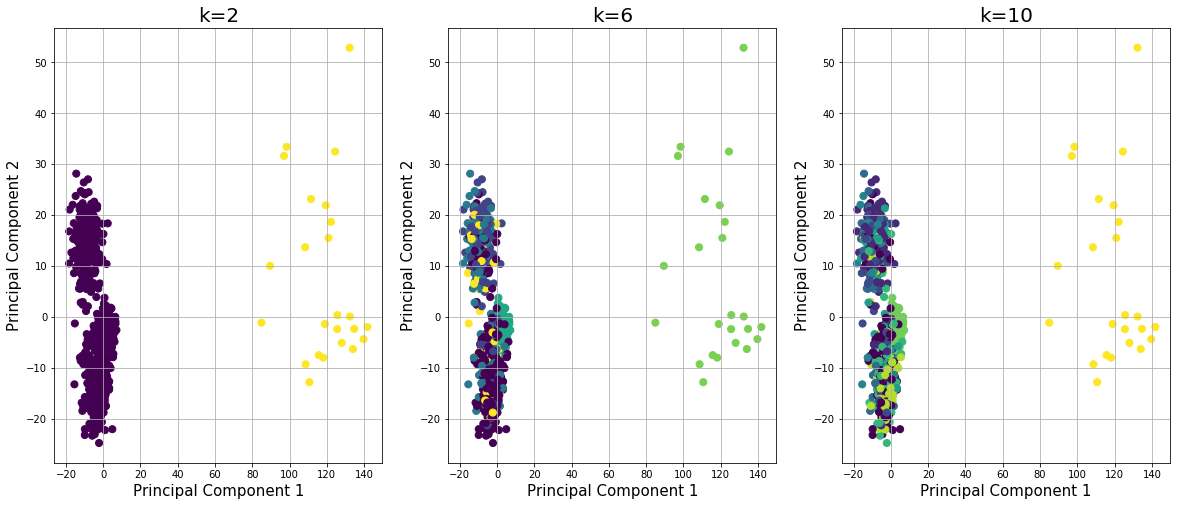

In [28]:
labels=[]   
for k in [2, 6, 10]:
    clustering=AgglomerativeClustering(n_clusters=k, affinity='euclidean', compute_full_tree='auto', linkage="ward")
    values=clustering.fit_predict(df_ms_cleaned)
    labels.append(values)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_ms_cleaned)
fig, axes = plt.subplots(1, 3, figsize=(20,8))
axes[0].set_xlabel('Principal Component 1', fontsize = 15)
axes[0].set_ylabel('Principal Component 2', fontsize = 15)
axes[0].set_title('k=2', fontsize = 20)
axes[0].scatter(principalComponents[:,0], principalComponents[:,1],c=labels[0], s=50)
axes[0].grid()
axes[1].set_xlabel('Principal Component 1', fontsize = 15)
axes[1].set_ylabel('Principal Component 2', fontsize = 15)
axes[1].set_title('k=6', fontsize = 20)
axes[1].scatter(principalComponents[:,0], principalComponents[:,1],c=labels[1], s=50)
axes[1].grid()
axes[2].set_xlabel('Principal Component 1', fontsize = 15)
axes[2].set_ylabel('Principal Component 2', fontsize = 15)
axes[2].set_title('k=10', fontsize = 20)
axes[2].scatter(principalComponents[:,0], principalComponents[:,1],c=labels[2], s=50)
axes[2].grid()

#### Birch clustering

In [29]:
K = range(2,20)
nmis={}
for k in K:
    brc = Birch(n_clusters=k)
    brc.fit_predict(df_ms_cleaned)
    nmi = metrics.normalized_mutual_info_score(df_ms["class"], brc.labels_, average_method="geometric")
    nmis[k]=nmi
max_k=max(nmis.items(), key=operator.itemgetter(1))[0]
print("The maximum NMI with Birch clustering is reached using {} clusters. The NMI value is {}.".format(max_k, round(nmis.get(max_k),2)))

The maximum NMI with Birch clustering is reached using 4 clusters. The NMI value is 0.51.


#### Mini-Batch clustering

In [30]:
for i in range(0,5):
    nmis={}
    for k in range(2,20):
        mbkmeans = MiniBatchKMeans(n_clusters=k)
        mbkmeans.fit_predict(df_ms_cleaned)
        nmi = metrics.normalized_mutual_info_score(df_ms["class"], mbkmeans.labels_, average_method="geometric")
        nmis[k]=nmi
    max_k=max(nmis.items(), key=operator.itemgetter(1))[0]
    print("The maximum NMI with Mini-Batch clustering is reached using {} clusters. The NMI value is {}.".format(max_k, round(nmis.get(max_k),2)))

The maximum NMI with Mini-Batch clustering is reached using 14 clusters. The NMI value is 0.26.
The maximum NMI with Mini-Batch clustering is reached using 7 clusters. The NMI value is 0.23.
The maximum NMI with Mini-Batch clustering is reached using 12 clusters. The NMI value is 0.17.
The maximum NMI with Mini-Batch clustering is reached using 7 clusters. The NMI value is 0.19.
The maximum NMI with Mini-Batch clustering is reached using 18 clusters. The NMI value is 0.22.


For minibatch clustering, the maximum NMI as well as the best performing number of clusters has some variation.

#### Gaussian Mixture

In [36]:
m = GaussianMixture(n_components=3)
m.fit(df_ms_cleaned)
gm_vals = m.predict(df_ms_cleaned)
round(metrics.normalized_mutual_info_score(df_ms["class"],gm_vals, average_method="geometric"),2)

0.2

Due to the long computation time, Gaussian mixture was not tested more extensively.

#### Spectral clustering

In [31]:
K = range(2,20)
nmis={}
for k in K:
    clustering = SpectralClustering(n_clusters=k)
    clustering.fit_predict(df_ms_cleaned)
    nmi = metrics.normalized_mutual_info_score(df_ms["class"], clustering.labels_, average_method="geometric")
    nmis[k]=nmi
max_k=max(nmis.items(), key=operator.itemgetter(1))[0]
print("The maximum NMI with Spectral clustering is reached using {} clusters. The NMI value is {}.".format(max_k, round(nmis.get(max_k),2)))

/usr/local/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/site-packages/sklea

The maximum NMI with Spectral clustering is reached using 18 clusters. The NMI value is 0.02.


### Feature engineering: Scaling

Next, let's try to improve the solutions by scaling the values.

In [32]:
x = df_ms_cleaned.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_ms_cleaned_minmax_scaled = pd.DataFrame(x_scaled)
df_ms_cleaned_minmax_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.653471,0.892607,0.742119,0.798357,0.649117,0.584171,0.715346,0.816403,0.715016,0.725033,...,0.740579,0.780618,0.763988,0.532612,0.844256,0.730324,0.751252,0.817999,0.739745,0.845812
1,0.862522,0.865354,0.865370,0.945777,0.780827,0.791571,0.911480,0.990376,0.614477,0.787404,...,0.872605,1.000000,0.911116,0.936165,0.941515,0.871619,0.799847,0.743186,0.926870,0.902605
2,0.816306,0.868808,0.832337,0.647616,0.624214,0.752617,0.817182,0.947744,0.787754,0.915341,...,0.748893,0.968342,0.951959,0.840052,0.905235,0.841283,0.798419,0.823871,0.896553,0.843242
3,0.878353,0.849007,0.842275,0.970690,0.708009,0.689336,0.709717,0.821562,0.600726,0.751547,...,0.777152,0.673524,0.751482,0.390820,0.806522,0.691345,0.738647,0.684275,0.773009,0.855776
4,0.819013,0.841821,0.924823,0.903286,0.763109,0.740571,0.774324,0.982772,0.926697,0.975985,...,0.880478,0.996462,0.915955,0.665510,0.922080,0.893549,0.809993,1.000000,0.909014,0.826201


In [34]:
x = df_ms_cleaned.values
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
df_ms_cleaned_standard_scaled = pd.DataFrame(x_scaled)
df_ms_cleaned_standard_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.087711,0.743481,0.654223,0.460459,0.194121,-0.193143,0.248234,0.237064,0.592898,0.196438,...,0.351207,0.704515,0.199400,-0.452143,0.554273,0.756305,0.439018,0.839665,0.068912,0.587890
1,0.896209,0.639774,1.150687,1.023650,0.746792,0.663605,1.028037,0.842536,0.171329,0.418216,...,0.847282,1.603438,0.737546,1.070310,0.900535,1.341116,0.630572,0.531149,0.723791,0.797695
2,0.717470,0.652918,1.017628,-0.115419,0.089624,0.502690,0.653119,0.694164,0.897895,0.873139,...,0.382447,1.473718,0.886937,0.707711,0.771373,1.215554,0.624943,0.863877,0.617690,0.578396
3,0.957435,0.577569,1.057658,1.118826,0.441239,0.241284,0.225855,0.255018,0.113668,0.290717,...,0.488628,0.265695,0.153659,-0.987068,0.419929,0.594975,0.389331,0.288209,0.185327,0.624697
4,0.727941,0.550222,1.390170,0.861321,0.672444,0.452931,0.482724,0.816071,1.480500,1.088777,...,0.876865,1.588942,0.755245,0.049232,0.831343,1.431881,0.670564,1.590200,0.661301,0.515445


Next, let's try out clustering with these new, scaled datasets and the best performing methods.

In [49]:
brc = Birch(n_clusters=4)
brc.fit_predict(df_ms_cleaned_minmax_scaled)
print("NMI with Birch, 4 clusters and minmax-scaled data: {}".format(round(metrics.normalized_mutual_info_score(df_ms["class"],brc.labels_, average_method="geometric"),2)))

NMI with Birch, 4 clusters and minmax-scaled data: 0.19


In [50]:
brc = Birch(n_clusters=4)
brc.fit_predict(df_ms_cleaned_standard_scaled)
print("NMI with Birch, 4 clusters and standard-scaled data: {}".format(round(metrics.normalized_mutual_info_score(df_ms["class"],brc.labels_, average_method="geometric"),2)))

NMI with Birch, 4 clusters and standard-scaled data: 0.3


In [51]:
clustering = AgglomerativeClustering(n_clusters=4, affinity='euclidean', compute_full_tree='auto', linkage="ward")
clusters=clustering.fit_predict(df_ms_cleaned_minmax_scaled)
print("NMI with Agglomerative clustering, 4 clusters and minmax-scaled data: {}".format(round(metrics.normalized_mutual_info_score(df_ms["class"],clusters, average_method="geometric"),2)))

NMI with Agglomerative clustering, 4 clusters and minmax-scaled data: 0.19


In [53]:
clustering = AgglomerativeClustering(n_clusters=4, affinity='euclidean', compute_full_tree='auto', linkage="ward")
clusters=clustering.fit_predict(df_ms_cleaned_standard_scaled)
print("NMI with Agglomerative clustering, 4 clusters and standard-scaled data: {}".format(round(metrics.normalized_mutual_info_score(df_ms["class"],clusters, average_method="geometric"),2)))

NMI with Agglomerative clustering, 4 clusters and standard-scaled data: 0.3


As can be seen, fitting with scaled data did not improve the performance but quite the opposite.

### Feature engineering: PCA

In [60]:
for i in range(0,5):
    pcas={}
    for pcnum in [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 200, 500, 600, 650]:
        pca = PCA(n_components=pcnum)
        pcs = pca.fit_transform(df_ms_cleaned)
        brc = Birch(n_clusters=4)
        brc.fit_predict(pcs)
        pcas[pcnum]=metrics.normalized_mutual_info_score(df_ms["class"],brc.labels_, average_method="geometric")
    max_val=max(pcas.items(), key=operator.itemgetter(1))[0]
    print("The maximum NMI with Birch clustering and PCA is reached using {} components. The NMI value is {}.".format(max_val, round(pcas.get(max_val),2)))

The maximum NMI with Birch clustering and PCA is reached using 4 components. The NMI value is 0.86.
The maximum NMI with Birch clustering and PCA is reached using 3 components. The NMI value is 0.87.
The maximum NMI with Birch clustering and PCA is reached using 5 components. The NMI value is 0.87.
The maximum NMI with Birch clustering and PCA is reached using 5 components. The NMI value is 0.83.
The maximum NMI with Birch clustering and PCA is reached using 4 components. The NMI value is 0.86.


As can be seen, the performance is increased by fitting the data after performing PCA. It can also be seen that the number of components has some variation. Let's try the same with scaled data.

In [59]:
for i in range(0,5):
    pcas={}
    for pcnum in [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 200, 500, 600, 650]:
        pca = PCA(n_components=pcnum)
        pcs = pca.fit_transform(df_ms_cleaned_minmax_scaled)
        brc = Birch(n_clusters=4)
        brc.fit_predict(pcs)
        pcas[pcnum]=metrics.normalized_mutual_info_score(df_ms["class"],brc.labels_, average_method="geometric")
    max_val=max(pcas.items(), key=operator.itemgetter(1))[0]
    print("The maximum NMI with Birch clustering, Minmax scaling, and PCA is reached using {} components. The NMI value is {}.".format(max_val, round(pcas.get(max_val),2)))

The maximum NMI with Birch clustering, Minmax scaling, and PCA is reached using 6 components. The NMI value is 0.62.
The maximum NMI with Birch clustering, Minmax scaling, and PCA is reached using 4 components. The NMI value is 0.62.
The maximum NMI with Birch clustering, Minmax scaling, and PCA is reached using 6 components. The NMI value is 0.61.
The maximum NMI with Birch clustering, Minmax scaling, and PCA is reached using 6 components. The NMI value is 0.62.
The maximum NMI with Birch clustering, Minmax scaling, and PCA is reached using 5 components. The NMI value is 0.6.


Scaling the data seems only to decrease the performance.

In [48]:
for i in range(0,5):
    pcas={}
    for pcnum in [2,5,10,20,50,100,200,500, 600, 650]:
        pca = PCA(n_components=pcnum)
        pcs = pca.fit_transform(df_ms_cleaned)
        clusterer = KMeans(n_clusters=2)
        labels = clusterer.fit_predict(pcs)
        pcas[pcnum]=metrics.normalized_mutual_info_score(df_ms["class"],labels, average_method="geometric")
    max_val=max(pcas.items(), key=operator.itemgetter(1))[0]
    print("The maximum NMI with K-means clustering, and PCA is reached using {} components. The NMI value is {}.".format(max_val, round(pcas.get(max_val),2)))

The maximum NMI with K-means clustering, and PCA is reached using 2 components. The NMI value is 0.7.
The maximum NMI with K-means clustering, and PCA is reached using 2 components. The NMI value is 0.68.
The maximum NMI with K-means clustering, and PCA is reached using 2 components. The NMI value is 0.69.
The maximum NMI with K-means clustering, and PCA is reached using 2 components. The NMI value is 0.69.
The maximum NMI with K-means clustering, and PCA is reached using 2 components. The NMI value is 0.68.


In [55]:
for i in range(0,5):
    pcas={}
    for pcnum in [2,5,10,20,50,100,200,500, 600, 650]:
        pca = PCA(n_components=pcnum)
        pcs = pca.fit_transform(df_ms_cleaned)
        clustering = AgglomerativeClustering(n_clusters=4, affinity='euclidean', compute_full_tree='auto', linkage="ward")
        clusters=clustering.fit_predict(df_ms_cleaned)
        pcas[pcnum]=metrics.normalized_mutual_info_score(df_ms["class"],labels, average_method="geometric")
    max_val=max(pcas.items(), key=operator.itemgetter(1))[0]
    print("The maximum NMI with Agglomerative clustering, and PCA is reached using {} components. The NMI value is {}.".format(max_val, round(pcas.get(max_val),2)))

The maximum NMI with Agglomerative clustering, and PCA is reached using 2 components. The NMI value is 0.06.
The maximum NMI with Agglomerative clustering, and PCA is reached using 2 components. The NMI value is 0.06.
The maximum NMI with Agglomerative clustering, and PCA is reached using 2 components. The NMI value is 0.06.
The maximum NMI with Agglomerative clustering, and PCA is reached using 2 components. The NMI value is 0.06.
The maximum NMI with Agglomerative clustering, and PCA is reached using 2 components. The NMI value is 0.06.


The best performing method was achieved by performing PCA (5 components), and performing Birch clustering for this data. The achieved NMI varies from 0.74 to 0.86. It is worth mentioning that sometimes, PCA with other component amounts tend to perform better.

### Feature engineering: Feature selection

In [56]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(df_ms_cleaned,df_ms["class"])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df_ms_cleaned.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best

      Specs      Score
4339  f4340  78.037198
2430  f2431  74.397723
3614  f3615  67.807381
3816  f3817  67.665916
910    f911  64.872084
1207  f1208  63.029748
1496  f1497  60.057672
4232  f4233  57.337520
3204  f3205  55.293856
860    f861  55.091094


In [61]:
for n in [2,10,50,100,150,200,300, 400, 500, 600, 700, 800, 900, 1000]:
    selected_data = df_ms_cleaned[featureScores.nlargest(n, "Score").Specs]
    brc = Birch(n_clusters=4)
    brc.fit_predict(selected_data)
    print("Number of features: {}. NMI: {}".format(n,round(metrics.normalized_mutual_info_score(df_ms["class"],brc.labels_, average_method="geometric"),2)))

Number of features: 2. NMI: 0.06
Number of features: 10. NMI: 0.07
Number of features: 50. NMI: 0.29
Number of features: 100. NMI: 0.65
Number of features: 150. NMI: 0.63
Number of features: 200. NMI: 0.69
Number of features: 300. NMI: 0.74
Number of features: 400. NMI: 0.76
Number of features: 500. NMI: 0.76
Number of features: 600. NMI: 0.77
Number of features: 700. NMI: 0.76
Number of features: 800. NMI: 0.77
Number of features: 900. NMI: 0.74
Number of features: 1000. NMI: 0.74


In [62]:
for n in [2,10,50,100,150,200,300,500,1000,1500]:
    selected_data = df_ms_cleaned[featureScores.nlargest(n, "Score").Specs]
    clustering = AgglomerativeClustering(n_clusters=4, affinity='euclidean', compute_full_tree='auto', linkage="ward")
    clusters=clustering.fit_predict(selected_data)
    print("Number of features: {}. NMI: {}".format(n,round(metrics.normalized_mutual_info_score(df_ms["class"],clusters, average_method="geometric"),2)))

Number of features: 2. NMI: 0.11
Number of features: 10. NMI: 0.07
Number of features: 50. NMI: 0.29
Number of features: 100. NMI: 0.65
Number of features: 150. NMI: 0.63
Number of features: 200. NMI: 0.69
Number of features: 300. NMI: 0.74
Number of features: 500. NMI: 0.76
Number of features: 1000. NMI: 0.74
Number of features: 1500. NMI: 0.71


In [73]:
for n in [100, 150, 200, 300, 500, 1000]:
    pcas={}
    for pcnum in [2, 5, 10, 20, 50, 100]:
        selected_data = df_ms_cleaned[featureScores.nlargest(n, "Score").Specs]
        pca = PCA(n_components=pcnum)
        pcs = pca.fit_transform(selected_data)
        brc = Birch(n_clusters=4)
        brc.fit_predict(pcs)
        pcas[pcnum]=metrics.normalized_mutual_info_score(df_ms["class"],brc.labels_, average_method="geometric")
    max_val=max(pcas.items(), key=operator.itemgetter(1))[0]
    print("Number of features: {}. PCA: {}. NMI: {}".format(n,max_val,round(pcas.get(max_val),2)))

Number of features: 100. PCA: 100. NMI: 0.65
Number of features: 150. PCA: 20. NMI: 0.79
Number of features: 200. PCA: 10. NMI: 0.82
Number of features: 300. PCA: 10. NMI: 0.86
Number of features: 500. PCA: 10. NMI: 0.9
Number of features: 1000. PCA: 10. NMI: 0.92


It seems like the most solid results are achieved by selecting around >500 most valuable features, performing PCA (around 10 components) on these, and using Birch clustering on them. This way NMI of 0.9 is achieved.

### Ensemble method

In [65]:
# Sort of ensemble method where Birch and Agglomerative clusterings are ran multiple times with different k-values, and the most common cluster is selected for each data point. 
def ensemble(data, pcs, k_list):
    labs=[]
    for pcnum in pcs:
        for k in k_list:
            pca = PCA(n_components=pcnum)
            pcs = pca.fit_transform(df_ms_cleaned)
            brc = Birch(n_clusters=k)
            brc.fit_predict(pcs)
            labs.append(brc.labels_)
            print(round(metrics.normalized_mutual_info_score(df_ms["class"],brc.labels_, average_method="geometric"),2))
            
            clustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean', compute_full_tree='auto', linkage="ward")
            clusters=clustering.fit_predict(df_ms_cleaned)
            labs.append(clusters)
            print(round(metrics.normalized_mutual_info_score(df_ms["class"],clusters, average_method="geometric"),2))
    return np.array(labs)

In [66]:
klist=[3,4,5]
pcs=[100,400,500]
cl_data=ensemble(df_ms_cleaned, pcs, klist)

0.34
0.24
0.43
0.51
0.43
0.48
0.14
0.24
0.48
0.51
0.44
0.48
0.23
0.24
0.38
0.51
0.23
0.48


In [67]:
def most_common(lst):
    return max(set(lst), key=lst.count)

labels=[]
for i in range(0,694):
    vals=[]
    for val in range(0,18):
        vals.append(cl_data[val,i])
    labels.append(most_common(vals))

In [69]:
round(metrics.normalized_mutual_info_score(df_ms["class"],labels, average_method="geometric"),2)

0.44

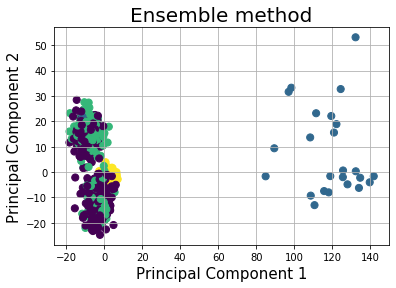

In [70]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_ms_cleaned)
plt.scatter(principalComponents[:,0], principalComponents[:,1],c=labels, s=50)
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('Ensemble method', fontsize = 20)
plt.grid()

Unfortunately, the used ensemble did not improve the performance. In general, the logic of the ensembling was probably way too simple, and more sophisticated algorithm would be needed for ensembling. 

### Optimizing the best performing method

It turned out that best results were achieved by combining feature selection with PCA and Birch clustering.

In [75]:
for k in [3, 4, 5, 6]:
    for n in [100, 150, 200, 300, 500, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 2500, 3000, 3500]:
        pcas={}
        for pcnum in [2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 50, 100]:
            selected_data = df_ms_cleaned[featureScores.nlargest(n, "Score").Specs]
            pca = PCA(n_components=pcnum)
            pcs = pca.fit_transform(selected_data)
            brc = Birch(n_clusters=k)
            brc.fit_predict(pcs)
            pcas[pcnum]=metrics.normalized_mutual_info_score(df_ms["class"],brc.labels_, average_method="geometric")
        max_val=max(pcas.items(), key=operator.itemgetter(1))[0]
        print("k: {}. Number of features: {}. PCA: {}. NMI: {}".format(k, n,max_val,round(pcas.get(max_val),2)))

k: 3. Number of features: 100. PCA: 100. NMI: 0.67
k: 3. Number of features: 150. PCA: 12. NMI: 0.79
k: 3. Number of features: 200. PCA: 10. NMI: 0.85
k: 3. Number of features: 300. PCA: 10. NMI: 0.9
k: 3. Number of features: 500. PCA: 5. NMI: 0.69
k: 3. Number of features: 800. PCA: 5. NMI: 0.73
k: 3. Number of features: 900. PCA: 5. NMI: 0.73
k: 3. Number of features: 1000. PCA: 5. NMI: 0.73
k: 3. Number of features: 1100. PCA: 2. NMI: 0.71
k: 3. Number of features: 1200. PCA: 2. NMI: 0.71
k: 3. Number of features: 1300. PCA: 5. NMI: 0.71
k: 3. Number of features: 1400. PCA: 2. NMI: 0.71
k: 3. Number of features: 1500. PCA: 2. NMI: 0.71
k: 3. Number of features: 2000. PCA: 8. NMI: 0.7
k: 3. Number of features: 2500. PCA: 2. NMI: 0.71
k: 3. Number of features: 3000. PCA: 2. NMI: 0.71
k: 3. Number of features: 3500. PCA: 2. NMI: 0.71
k: 4. Number of features: 100. PCA: 100. NMI: 0.65
k: 4. Number of features: 150. PCA: 13. NMI: 0.78
k: 4. Number of features: 200. PCA: 7. NMI: 0.82
k: 4

In [105]:
pcnum = 5
feature_list = [800, 850, 900, 950]
k = 4

for features in feature_list:
        results=[]
        for i in range(0,100):
            bestfeatures = SelectKBest(score_func=chi2, k=10)
            fit = bestfeatures.fit(df_ms_cleaned,df_ms["class"])
            dfscores = pd.DataFrame(fit.scores_)
            dfcolumns = pd.DataFrame(df_ms_cleaned.columns)
            featureScores = pd.concat([dfcolumns,dfscores],axis=1)
            featureScores.columns = ['Specs','Score']
            selected_data = df_ms_cleaned[featureScores.nlargest(features, "Score").Specs]
            
            pca = PCA(n_components=pcnum)
            pcs = pca.fit_transform(selected_data)
            brc = Birch(n_clusters=k)
            brc.fit_predict(pcs)
            val = metrics.normalized_mutual_info_score(df_ms["class"],brc.labels_, average_method="geometric")
            results.append(val)
        print("Average NMI for {} features and {} pcas: {}".format(features, pcnum, round((sum(results)/len(results)),4)))

Average NMI for 800 features and 5 pcas: 0.9236
Average NMI for 850 features and 5 pcas: 0.9232
Average NMI for 900 features and 5 pcas: 0.9281
Average NMI for 950 features and 5 pcas: 0.9256


The best configuration that was found consist of the following parts:
* Selecting k best features, where k=900.
* Performing PCA with 5 components.
* Clustering using Birch clustering and 4 clusters.

The resulted NMI is on average 0.93.

In [125]:
import random
features = [800, 850, 900, 950, 1000, 1100, 1500]
K = [3,4,5]
K2 = [10, 50, 100, 1000]
pcnums = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
ths = [0.1, 0.3, 0.5, 0.7, 1.0, 2.0, 3.0]
bfs = [10, 50, 100]
score_function = [f_classif, chi2]

for i in range(0,100):
    feature=random.choice(features)
    k=random.choice(K)
    k2=random.choice(K2)
    pcnum=random.choice(pcnums)
    th=random.choice(ths)
    bf=random.choice(bfs)
    sf = random.choice(score_function)
    if pcnum > feature:
        continue
    results = []
    bestfeatures = SelectKBest(score_func=sf, k=k2)
    fit = bestfeatures.fit(df_ms_cleaned,df_ms["class"])
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_ms_cleaned.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']
    selected_data = df_ms_cleaned[featureScores.nlargest(feature, "Score").Specs]
    pca = PCA(n_components=pcnum)
    pcs = pca.fit_transform(selected_data)
    for j in range(0,20):
        brc = Birch(n_clusters=k, threshold=th, branching_factor=bf)
        brc.fit_predict(pcs)
        val = metrics.normalized_mutual_info_score(df_ms["class"],brc.labels_, average_method="geometric")
        results.append(val)
    avg_nmi = sum(results)/len(results)
    if avg_nmi > 0.92:
        print("Average NMI for {} clusters, {} features, {} pcas, {} threshold, {} branching factor, score_func {}, and {} best features: {}".format(k, feature, pcnum, th, bf, str(sf), k2, round((sum(results)/len(results)),4)))

Average NMI for 4 clusters, 850 features, 8 pcas, 2.0 threshold, 50 branching factor, score_func <function chi2 at 0x13b1cd3b0>, and 50 best features: 0.9284
Average NMI for 4 clusters, 950 features, 6 pcas, 1.0 threshold, 10 branching factor, score_func <function chi2 at 0x13b1cd3b0>, and 100 best features: 0.9284
Average NMI for 5 clusters, 1000 features, 4 pcas, 0.1 threshold, 50 branching factor, score_func <function f_classif at 0x13b0b5830>, and 50 best features: 0.9249
Average NMI for 5 clusters, 1100 features, 3 pcas, 0.5 threshold, 100 branching factor, score_func <function chi2 at 0x13b1cd3b0>, and 1000 best features: 0.9249
Average NMI for 5 clusters, 1500 features, 5 pcas, 1.0 threshold, 50 branching factor, score_func <function f_classif at 0x13b0b5830>, and 1000 best features: 0.9249
Average NMI for 4 clusters, 900 features, 3 pcas, 1.0 threshold, 50 branching factor, score_func <function chi2 at 0x13b1cd3b0>, and 1000 best features: 0.9371
Average NMI for 4 clusters, 850

In [4]:
results=[]
nmi_max=0
for i in range(0,20):
    # Select best 900 features
    bestfeatures = SelectKBest(score_func=chi2, k=1000)
    fit = bestfeatures.fit(df_ms_cleaned,df_ms["class"])
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_ms_cleaned.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']
    selected_data = df_ms_cleaned[featureScores.nlargest(900, "Score").Specs]
    
    # Perform PCA for 5 components
    pca = PCA(n_components=5)
    pcs = pca.fit_transform(selected_data)
    
    # Perform Birch clustering to 4 clusters
    brc = Birch(n_clusters=4, threshold=1.0, branching_factor=50)
    brc.fit_predict(pcs)
    
    # Measure NMI
    nmi = metrics.normalized_mutual_info_score(df_ms["class"],brc.labels_, average_method="geometric")
    if(nmi>nmi_max):
        ms_labels=brc.labels_
    results.append(nmi)
    print("NMI: {}".format(round(nmi,3)))
print("MS_DATA NMI average for 20 runs: {}".format(round(sum(results)/len(results),3)))

NMI: 0.929
NMI: 0.911
NMI: 0.929
NMI: 0.921
NMI: 0.937
NMI: 0.928
NMI: 0.937
NMI: 0.937
NMI: 0.928
NMI: 0.929
NMI: 0.92
NMI: 0.937
NMI: 0.937
NMI: 0.929
NMI: 0.937
NMI: 0.937
NMI: 0.922
NMI: 0.92
NMI: 0.929
NMI: 0.937
MS_DATA NMI average for 20 runs: 0.93
